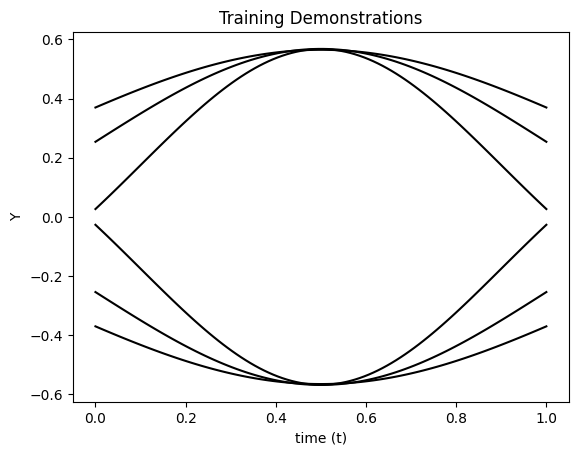

In [28]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

X1, X2, Y1, Y2 = utils.generate_demonstrations(time_len=100, plot_title='Training')

In [29]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 5
d_N = 3
time_len = 100

model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

idx=0
target_demo = Y2[idx]
target_demo = torch.from_numpy(target_demo).double()

errors = []
losses = []
best_mean = torch.zeros(0)
best_std = torch.zeros(0)

condition_points = [0,99]

EPOCHS = 200000

Epoch: 0, Loss: 1.374811914873601


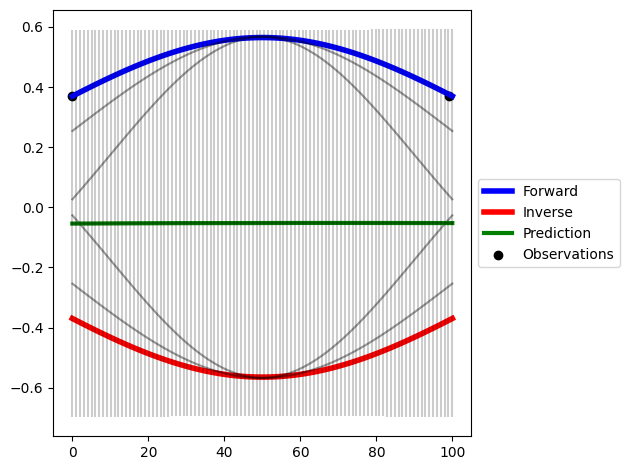

Epoch: 10000, Loss: 0.766325912811771


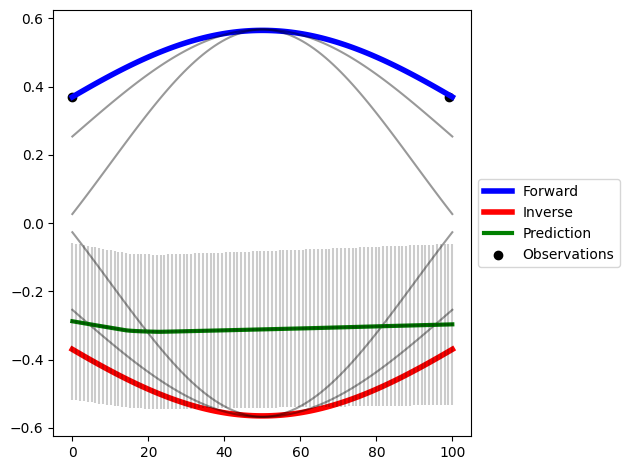

Epoch: 20000, Loss: -2.706141893405944


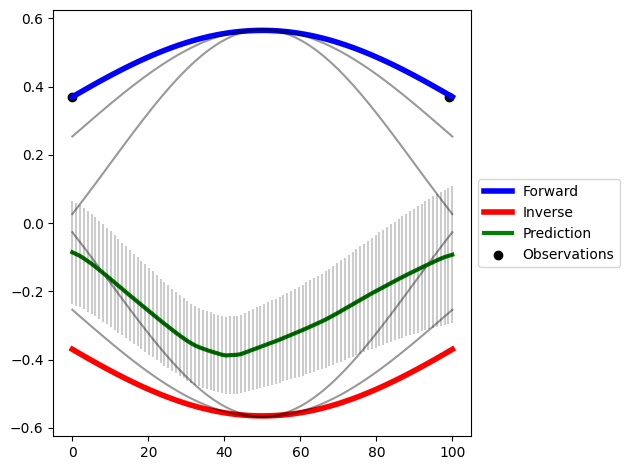

Epoch: 30000, Loss: -3.7097193961803128


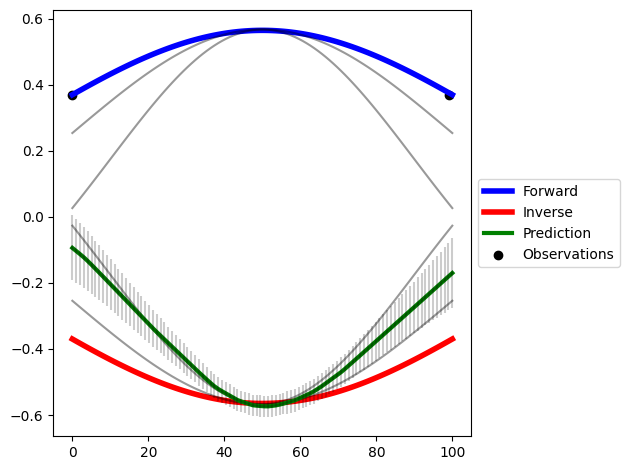

Epoch: 40000, Loss: -5.78161532133017


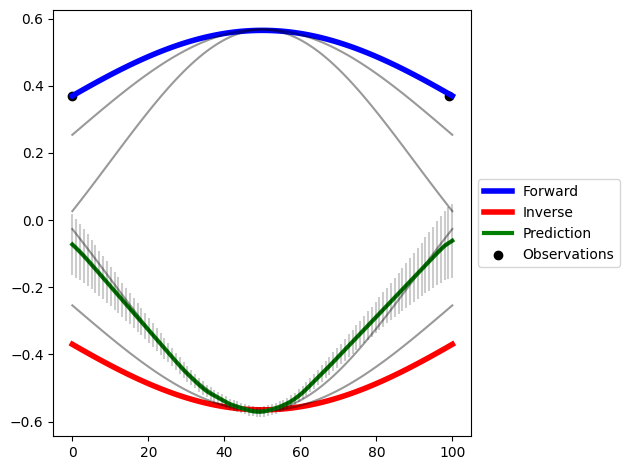

Epoch: 50000, Loss: -6.386249293878205


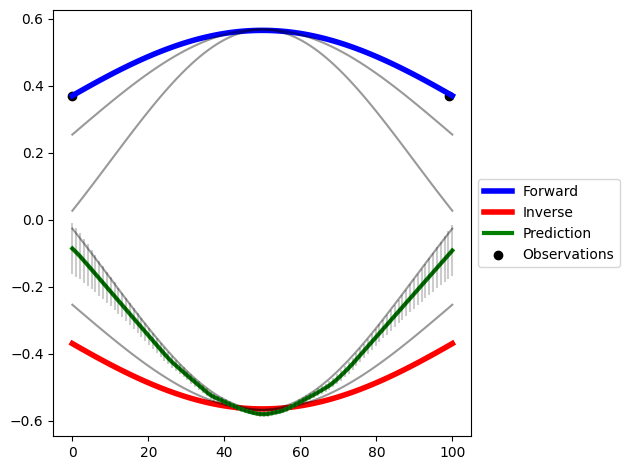

Epoch: 60000, Loss: -5.273273415888493


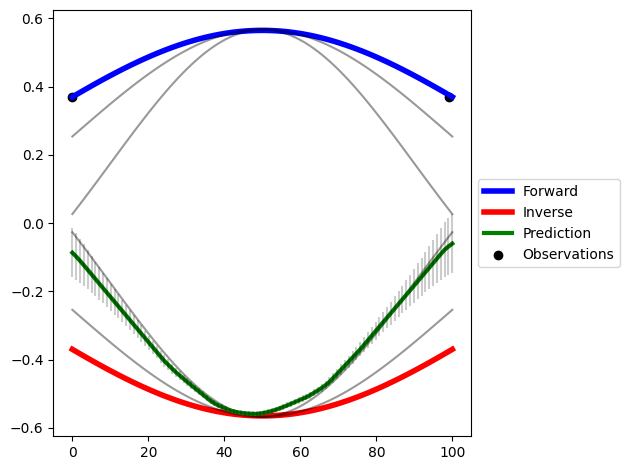

Epoch: 70000, Loss: -6.622950849487196


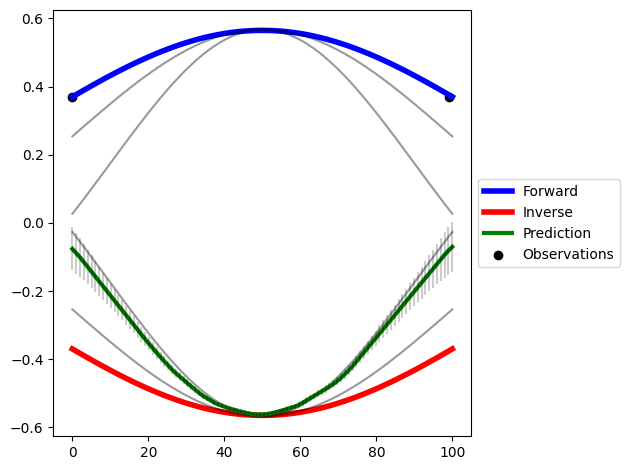

Epoch: 80000, Loss: -5.995487451653647


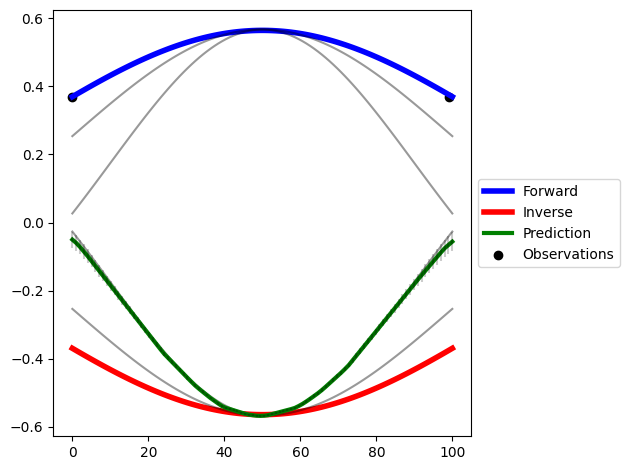

KeyboardInterrupt: 

In [30]:
for i in range(EPOCHS):

    obs, x_tar, y_tar = dual_enc_dec_cnmp.get_training_sample(X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)

    optimizer.zero_grad()

    output = model(obs, x_tar)
    loss = dual_enc_dec_cnmp.log_prob_loss(output, y_tar, d_y1)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        if i % 1000 == 0:
            if i % 10000 == 0:
                print(f'Epoch: {i}, Loss: {loss.item()}')
                means, stds = dual_enc_dec_cnmp.predict_inverse(model, idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                errors, best_mean, best_std = utils.test_model(best_mean, best_std, means, stds, idx, demo_data, errors, time_len, condition_points, i, plot=True)
                torch.save(model.state_dict(), 'cnmp_best_model.pth')
                continue
            means, stds = dual_enc_dec_cnmp.predict_inverse(model, idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
            errors, best_mean, best_std = utils.test_model(best_mean, best_std, means, stds, idx, demo_data, errors, time_len, condition_points, i, plot=False)
            torch.save(model.state_dict(), 'cnmp_best_model.pth')
            continue
        losses.append(loss.item())

    
utils.plot_results(best_mean, best_std, Y1, Y2, idx, condition_points, losses, errors, time_len, d_N)